# EP03 - Visão e processamento de imagens

Integrantes: 

- Bruna Lobato - 10666972
- Felipe Noronha - 10737032
- Izabela Fonsceca - 11583721

---

Você pode conferir as entregas anteriores e todas as imagens que constituem a base de dados no [GitHub do projeto](https://github.com/fcnoronha/visao-e-prcessamento-de-imagens).

## 0. Introdução

Esse Jupyter Notebook representa o exercicio programa 3, que consiste em realizar a **segmentação das imagens dos objetos** e **classificação dos objetos utilizando aprendizado de maquina**.

In [84]:
import os
import random
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from scipy.ndimage import binary_fill_holes
from cv2 import boundingRect, rectangle

from skimage import io
from skimage.transform import resize 
from skimage.filters import threshold_sauvola
from skimage.metrics import adapted_rand_error
from skimage.morphology import remove_small_objects
from skimage.util import img_as_ubyte, img_as_float, img_as_int

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# caminhos para os datasets
RAW_PATH = 'datasets/raw/'
GREY_PATH = 'datasets/original-gray/'
NORM_PATH = 'datasets/normalized/'
AUG_PATH = 'datasets/augmented/'
MANUAL_SEGMENTED_PATH = 'datasets/segmented/manual/'
AUTOM_SEGMENTED_PATH = 'datasets/segmented/automated/'
MANUAL_FERET_PATH = 'datasets/feret_box/manual/'
AUTOM_FERET_PATH = 'datasets/feret_box/automated/'

# Parte 1. Segmentação e Feret Box

A segmentação consiste em demarcar o objeto de interesse na imagem. Em particular, criamos uma imagem binaria onde os pixels com valor 1 cobrem o objeto e os com valor 0 cobrem o fundo. Utilizamos dois metodos para geração das imagens segmentadas:

- Manual, onde utilizamos um editor de imagens para geração de segmentações que oferecessem um _ground-truth_, e
- Automática, utilizando funções da biblioteca `skimage` para tornar a classificação de todas as imagens do dataset algo factivel.

Além disso, nessa parte, vamos gerar as _Feret Boxes_ das imagens segmentadas, tanto manualmente quanto automaticamente.

## 1.1 Segmentação manual

Para realizar a segmentação manual, selecionamos 175 imagens aleatorias da nossa base de dados original, o que representa 15% das imagens. Em seguida, usamos o software de edição de imagens GIMP para criar as segmentações. As imagens dessa parte ficam em `datasets/segmented/manual`.

Uma pequena amostra das imagens segmentadas é apresentada a seguir.

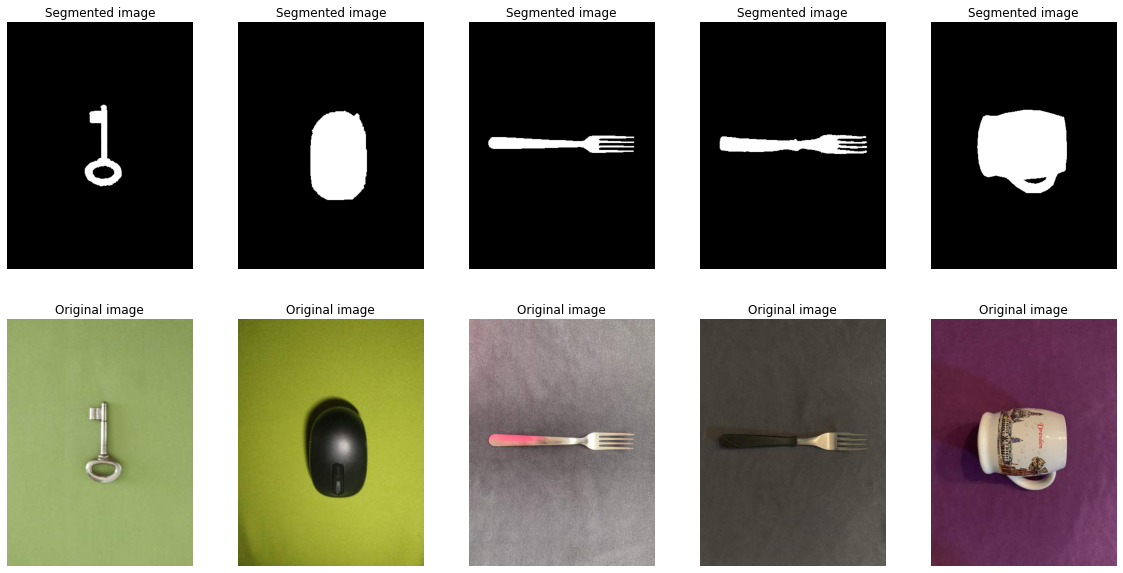

In [60]:
n_images_to_show = 5
selection = np.random.choice(os.listdir(MANUAL_SEGMENTED_PATH), n_images_to_show)

fig, ax = plt.subplots(2, n_images_to_show, figsize = (20, 10))
for i, file_name in zip(range(6), selection):
    
    segmented_image = io.imread(MANUAL_SEGMENTED_PATH + file_name)
    ax[0, i%n_images_to_show].imshow(segmented_image, cmap='gray')
    ax[0, i%n_images_to_show].axis('off')
    ax[0, i%n_images_to_show].set_title('Segmented image')

    original_image = io.imread(RAW_PATH + file_name[:-3] + 'jpg')
    ax[1, i%n_images_to_show].imshow(original_image, cmap='gray')
    ax[1, i%n_images_to_show].axis('off')
    ax[1, i%n_images_to_show].set_title('Original image')

plt.show()

## 1.2 Segmentação automatica

Para lidar com as mais de mil imagens originais, vamos utilizar metodos da biblioteca `skimage` para realizarmos a segmentação automatica utilizando o metodo [`threshold_sauvola`](https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.threshold_sauvola). Além disso, vamos usar o metodo [`binary_fill_holes`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.ndimage.morphology.binary_fill_holes.html) do _ndimage_ para preencher buracos na segmentação junto com o [`remove_small_objects`](https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects) para remover pontinhos da imagem.

As imagens dessa parte ficam em `datasets/segmented/automated`.


In [38]:
def segment_image(image):
    
    threshold = threshold_sauvola(image, window_size=35)
    mask = image > threshold

    # invert if the object (smaller part) is not white
    n_black = np.count_nonzero(mask == False)
    n_white = np.count_nonzero(mask == True)
    if (n_white > n_black):
        mask = np.bitwise_not(mask)

    mask_without_points = remove_small_objects(mask > 0, 64)
    segmentation_filled = binary_fill_holes(mask_without_points)

    return segmentation_filled

for file in os.listdir(GREY_PATH):
        
    image_name = file.split('.')[0]
    image = io.imread(GREY_PATH + file, as_gray=True)
    segmentation = segment_image(image)

    io.imsave(AUTOM_SEGMENTED_PATH + image_name + '.png', img_as_ubyte(segmentation), check_contrast=False)

Abaixo, podemos ver alguns exemplos das imagens segmentadas automaticamente.

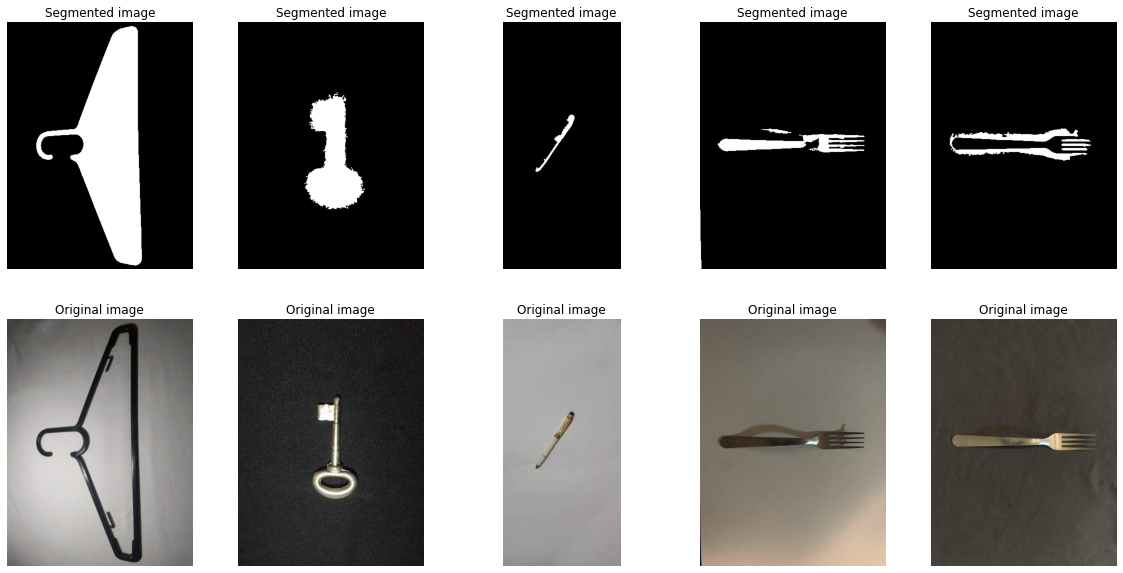

In [61]:
n_images_to_show = 5
selection = np.random.choice(os.listdir(AUTOM_SEGMENTED_PATH), n_images_to_show)

fig, ax = plt.subplots(2, n_images_to_show, figsize = (20, 10))
for i, file_name in zip(range(6), selection):
    
    segmented_image = io.imread(AUTOM_SEGMENTED_PATH + file_name)
    ax[0, i%n_images_to_show].imshow(segmented_image, cmap='gray')
    ax[0, i%n_images_to_show].axis('off')
    ax[0, i%n_images_to_show].set_title('Segmented image')

    original_image = io.imread(RAW_PATH + file_name[:-3] + 'jpg')
    ax[1, i%n_images_to_show].imshow(original_image, cmap='gray')
    ax[1, i%n_images_to_show].axis('off')
    ax[1, i%n_images_to_show].set_title('Original image')

plt.show()

## 1.3 Feret box

Abaixo, usamos metodos da biblioteca _cv2_ para calcular as _feret boxes_ das segmentações.

In [65]:
def generate_feret_box(image):

    x_left, y_top, width, heigth = boundingRect(image)
    feret_box = rectangle(image, (x_left, y_top), (x_left+width, y_top+heigth), 255, -1)
    return feret_box

for file in os.listdir(AUTOM_SEGMENTED_PATH):
        
    image = io.imread(AUTOM_SEGMENTED_PATH + file, as_gray=True)
    feret_box = generate_feret_box(image.astype(np.uint8))

    io.imsave(AUTOM_FERET_PATH + file, img_as_ubyte(feret_box), check_contrast=False)

for file in os.listdir(MANUAL_SEGMENTED_PATH):
        
    image = io.imread(MANUAL_SEGMENTED_PATH + file, as_gray=True)
    feret_box = generate_feret_box(image.astype(np.uint8))

    io.imsave(MANUAL_FERET_PATH + file, img_as_ubyte(feret_box), check_contrast=False)

Abaixo, podemos ver algumas _feret boxes_ geradas a partir das imagens segmentadas manualmente.

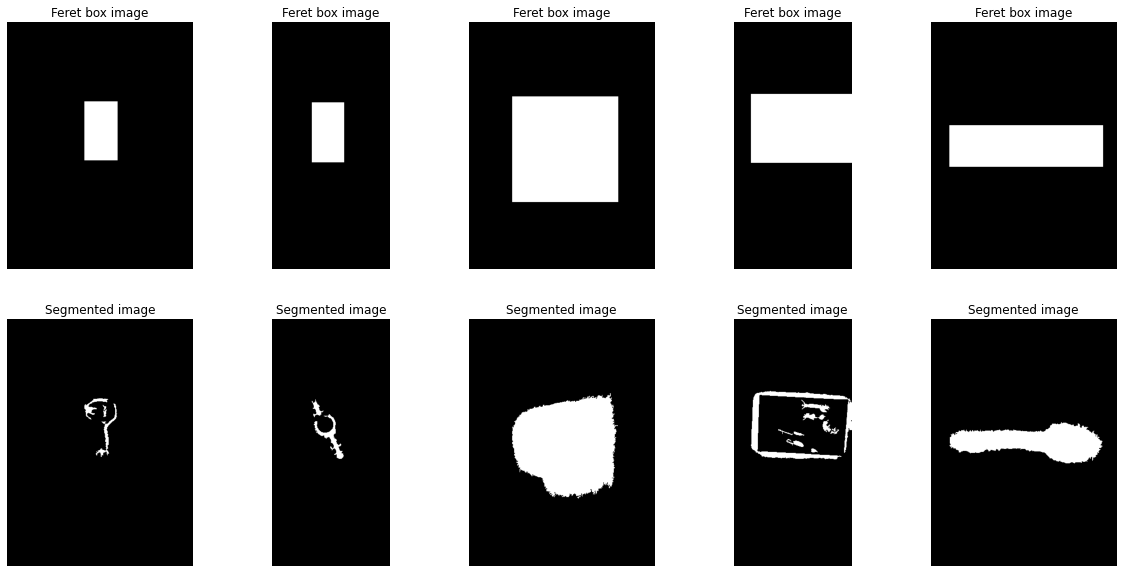

In [66]:
n_images_to_show = 5
selection = np.random.choice(os.listdir(AUTOM_SEGMENTED_PATH), n_images_to_show)

fig, ax = plt.subplots(2, n_images_to_show, figsize = (20, 10))
for i, file_name in zip(range(6), selection):
    
    segmented_image = io.imread(AUTOM_FERET_PATH + file_name)
    ax[0, i%n_images_to_show].imshow(segmented_image, cmap='gray')
    ax[0, i%n_images_to_show].axis('off')
    ax[0, i%n_images_to_show].set_title('Feret box image')

    original_image = io.imread(AUTOM_SEGMENTED_PATH + file_name)
    ax[1, i%n_images_to_show].imshow(original_image, cmap='gray')
    ax[1, i%n_images_to_show].axis('off')
    ax[1, i%n_images_to_show].set_title('Segmented image')

plt.show()

# Parte 2. Extração de features, PCA e classificação



In [46]:
# vector with (feature, file name) pairs
features_extracted = []
for file in random.sample(os.listdir(AUG_PATH), 500): # TIRAR O SAMPLE

    file_name = file.split('.')[0]

    if (file_name.split('_')[-1] == 'col'): continue
    image = io.imread(AUG_PATH + file, as_gray=True)

    name_without_aug_suffix = file_name[:file_name.rfind('_')]
    feret_box = io.imread(AUTOM_FERET_PATH + name_without_aug_suffix + '.png', as_gray=True)
    x_left, y_top, width, heigth = boundingRect(feret_box)

    image_cropped = image[y_top:y_top+heigth, x_left:x_left+width]
    image_resized = resize(image_cropped, (400, 400), anti_aliasing=True)
    image_flattened = pd.Series(image_resized.flatten())
    features_extracted.append(( image_flattened, name_without_aug_suffix ))

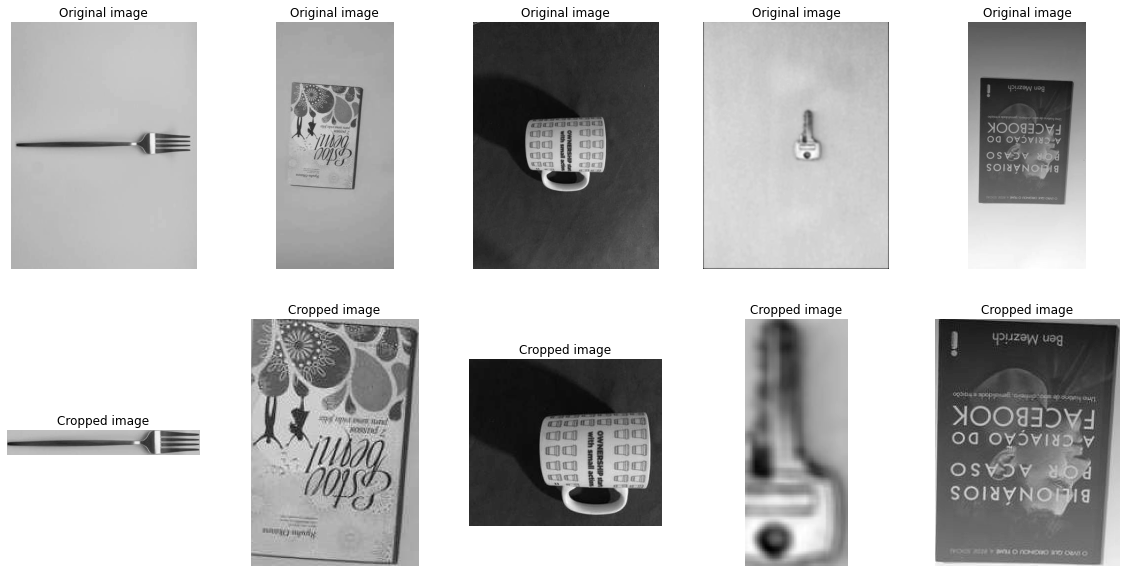

In [4]:
n_images_to_show = 5
selection = np.random.choice(os.listdir(AUG_PATH), n_images_to_show)

fig, ax = plt.subplots(2, n_images_to_show, figsize = (20, 10))
for i, file in zip(range(6), selection):
    
    file_name = file.split('.')[0]
    if (file_name.split('_')[-1] == 'col'): continue
    
    image = io.imread(AUG_PATH + file, as_gray=True)
    ax[0, i%n_images_to_show].imshow(image, cmap='gray')
    ax[0, i%n_images_to_show].axis('off')
    ax[0, i%n_images_to_show].set_title('Original image')

    name_without_aug_suffix = file_name[:file_name.rfind('_')]
    feret_box = io.imread(AUTOM_FERET_PATH + name_without_aug_suffix + '.png', as_gray=True)
    x_left, y_top, width, heigth = boundingRect(feret_box)
    image_cropped = image[y_top:y_top+heigth, x_left:x_left+width]
    ax[1, i%n_images_to_show].imshow(image_cropped, cmap='gray')
    ax[1, i%n_images_to_show].axis('off')
    ax[1, i%n_images_to_show].set_title('Cropped image')

plt.show()    

In [47]:
file_names = [file.split('.')[0] for file in os.listdir(GREY_PATH)]
random.shuffle(file_names)

n_samples = len(file_names)
n_train = int(n_samples * 0.7)
n_test = int(n_samples * 0.2)
n_val = n_samples - n_train - n_test

train_names = file_names[:n_train]
test_names = file_names[n_train:n_train+n_test]
val_names = file_names[n_train+n_test:]

In [48]:
x_train = []
y_train = []
x_test = []
y_test = []
x_val = []
y_val = []

for feature, name in features_extracted:
    
    obj = name.split('_')[0]
    if name in train_names:
        x_train.append(feature)
        y_train.append(obj)
    elif name in test_names:
        x_test.append(feature)
        y_test.append(obj)
    else:
        x_val.append(feature)
        y_val.append(obj)

In [81]:
pca = PCA(n_components=.97) # queremos manter 90% da variancia
pca.fit(pd.DataFrame(x_train))

x_train_pca = pca.transform(pd.DataFrame(x_train))
x_test_pca = pca.transform(pd.DataFrame(x_test))
x_val_pca = pca.transform(pd.DataFrame(x_val))

print('Components after PCA:', x_train_pca.shape[1])

Components after PCA: 77


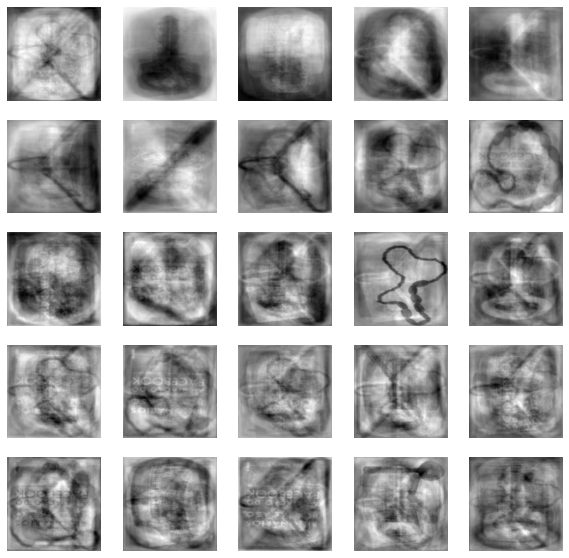

In [82]:
# visualizando Eigenvectors https://medium.com/@sebastiannorena/pca-principal-components-analysis-applied-to-images-of-faces-d2fc2c083371

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(400,400), cmap='gray')
    ax.axis('off')

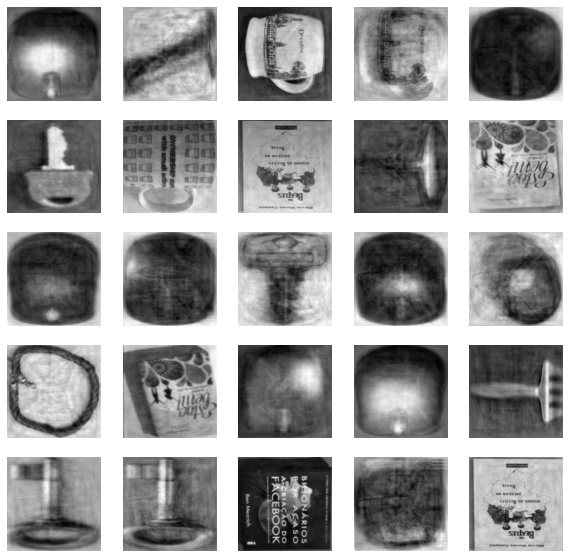

In [83]:
images_pca = pca.inverse_transform(x_train_pca)

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(images_pca[i].reshape(400, 400),cmap="gray")
    ax.axis('off')

In [88]:
from time import time
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(
    SVC(kernel='rbf', class_weight='balanced'), param_grid
)
clf = clf.fit(x_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)




Fitting the classifier to the training set
done in 2.669s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.0001)


In [91]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(x_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Predicting people's names on the test set
done in 0.004s
              precision    recall  f1-score   support

      cabide       1.00      0.80      0.89         5
      caneca       0.62      0.83      0.71         6
      caneta       0.25      1.00      0.40         3
       chave       0.92      0.79      0.85        14
       colar       0.67      0.44      0.53         9
      colher       0.55      0.50      0.52        12
       garfo       0.50      0.29      0.36         7
       livro       0.83      0.45      0.59        11
       mouse       1.00      1.00      1.00         9
     relogio       0.25      0.50      0.33         4

    accuracy                           0.64        80
   macro avg       0.66      0.66      0.62        80
weighted avg       0.72      0.64      0.65        80

[[ 4  0  1  0  0  0  0  0  0  0]
 [ 0  5  0  0  0  0  0  1  0  0]
 [ 0  0  3  0  0  0  0  0  0  0]
 [ 0  0  2 11  0  0  0  0  0  1]
 [ 0  0  0  0  4  0  2  0  0  3]
 [ 0  2  3  0  1  6

# Para ver

- Precisa de train, test e validation mesmo?
- No PCA só pode entrar dados com a mesma dimensão? Por isso eu coloquei o resize nos crops com a feret box
- Tem que tirar o sample na parte de feature extraction quando for rodar real oficial

# Parte 3. Metricas e relatorio




Para encontrar os melhores parametros, fizemos uma busca com a intenção de minimizar o [`adapted_rand_error`](https://scikit-image.org/docs/dev/api/skimage.metrics.html#skimage.metrics.adapted_rand_error) que compara a imagem _ground truth_ com a segmentação. Usamos esses parametros para segmentar todas as imagens.

Mais informações sobre as tecnicas aqui usadas podem ser encontradas [neste tutorial](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_metrics.html).

In [32]:


def calculate_error_from_parameters(sigma, low_t, high_t, min_size):
    
    error_list = []
    for file in os.listdir(MANUAL_SEGMENTED_PATH):

        if (os.path.isdir(MANUAL_SEGMENTED_PATH + file)): continue

        ground_truth_image = img_as_int(io.imread(MANUAL_SEGMENTED_PATH + file, as_gray=True))
        image = io.imread(GREY_PATH + file[:-3] + 'jpg')
        segmentation = segment_image(image, sigma, low_t, high_t, min_size)

        error, precision, recall = adapted_rand_error(ground_truth_image, segmentation)
        error_list.append(error)
    
    return np.mean(error_list)